In [1]:
#Import Libraries and Dependencies
import os
import plaid
import requests
import datetime
import json
import pandas as pd
import pprint
%matplotlib inline

In [2]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
# Bring Env Variables into Python/Store in Variables
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SBX_SECRET_KEY = os.getenv('PLAID_SBX_SECRET_KEY')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_ENV', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')

# Plaid Access Token

In this section, you will use the plaid-python api to generate the correct authentication tokens to access data in the free developer Sandbox. This mimics how you might connect to your own account or a customer account, but due to privacy issues, this homework will only require connecting to and analyzing the fake data from the developer sandbox that Plaid provides. 

Complete the following steps to generate an access token:
1. Create a client to connect to plaid
2. Use the client to generate a public token and request the following items: 
['transactions', 'income', 'assets']
3. Exchange the public token for an access token
4. Test the access token by requesting and printing the available test accounts

### 1. Create a client to connect to plaid

In [4]:
INSTITUTION_ID = "ins_109508"

In [5]:
client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SBX_SECRET_KEY, public_key=PLAID_PUBLIC_KEY, environment='sandbox')

### 2. Generate a public token

In [6]:
token_response = client.Sandbox.public_token.create(INSTITUTION_ID, ['transactions','income','assets'])

### 3. Exchange the public token for an access token

In [7]:
exchange_response = client.Item.public_token.exchange(token_response['public_token'])

#Store access token as variable.
access_token = exchange_response['access_token']
access_token

'access-sandbox-be0bad1f-59e2-4d35-8be4-63fff5b25c97'

### 4. Fetch Accounts

In [8]:
client.Accounts.get(access_token)

{'accounts': [{'account_id': 'mNA6B7786vFWnAprzQR1IDN5PAkDW8CLR7pnA',
   'balances': {'available': 100,
    'current': 110,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '0000',
   'name': 'Plaid Checking',
   'official_name': 'Plaid Gold Standard 0% Interest Checking',
   'subtype': 'checking',
   'type': 'depository'},
  {'account_id': 'ygr6Zyy86wIKL148vxNbhzdQLgGzKoCykrnb5',
   'balances': {'available': 200,
    'current': 210,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '1111',
   'name': 'Plaid Saving',
   'official_name': 'Plaid Silver Standard 0.1% Interest Saving',
   'subtype': 'savings',
   'type': 'depository'},
  {'account_id': '9e6ogDD9oJIK394zljrxhyLwKGxykqhRzlywk',
   'balances': {'available': None,
    'current': 1000,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '2222',
   'name': 'Plaid CD',
   'officia

---

# Account Transactions with Plaid

In this section, you will use the Plaid Python SDK to connect to the Developer Sandbox account and grab a list of transactions. You will need to complete the following steps:


1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

### 1. Fetch the Transactions for the last 90 days

In [9]:
# Extract Transactions with Specific Date Range
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-90))
end_date = '{:%Y-%m-%d}'.format(datetime.datetime.now()) 
transactions_response = client.Transactions.get(access_token, start_date, end_date)

In [10]:
#Print Output
transactions = json.dumps(transactions_response['transactions'], indent=4)
print(transactions)

[
    {
        "account_id": "ygr6Zyy86wIKL148vxNbhzdQLgGzKoCykrnb5",
        "account_owner": null,
        "amount": 25,
        "authorized_date": null,
        "category": [
            "Payment",
            "Credit Card"
        ],
        "category_id": "16001000",
        "date": "2020-01-16",
        "iso_currency_code": "USD",
        "location": {
            "address": null,
            "city": null,
            "country": null,
            "lat": null,
            "lon": null,
            "postal_code": null,
            "region": null,
            "store_number": null
        },
        "name": "CREDIT CARD 3333 PAYMENT *//",
        "payment_channel": "other",
        "payment_meta": {
            "by_order_of": null,
            "payee": null,
            "payer": null,
            "payment_method": null,
            "payment_processor": null,
            "ppd_id": null,
            "reason": null,
            "reference_number": null
        },
        "pending": fals

### 2. Print the categories for each transaction

In [11]:
for transactions in transactions_response['transactions']:
    print(transactions['category'][0])

Payment
Travel
Transfer
Transfer
Recreation
Travel
Food and Drink
Food and Drink
Food and Drink
Transfer
Travel
Travel
Food and Drink
Payment
Food and Drink
Shops


### 3. Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

(For categories with more than one label, just use the first category label in the list)

In [12]:
dates = []
names = []
amounts = []
categories = []

for transactions in transactions_response['transactions']:
    categories.append(transactions['category'][0])
    dates.append(transactions['date'])
    names.append(transactions['name'])
    amounts.append(transactions['amount'])

df = pd.DataFrame(list(zip(dates, names, amounts, categories)), columns =['Date','Name','Amount','Category'])
df.head()

,Date,Name,Amount,Category
0,2020-01-16,CREDIT CARD 3333 PAYMENT *//,25.0,Payment
1,2020-01-16,Uber 063015 SF**POOL**,5.4,Travel
2,2020-01-15,ACH Electronic CreditGUSTO PAY 123456,5850.0,Transfer
3,2020-01-15,CD DEPOSIT .INITIAL.,1000.0,Transfer
4,2020-01-14,Touchstone Climbing,78.5,Recreation


### 4. Convert the data types to the appropriate types 

(i.e. datetimeindex for the date and float for the amount)

In [13]:
df.dtypes

Date         object
Name         object
Amount      float64
Category     object
dtype: object

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
print(df.dtypes)

Name         object
Amount      float64
Category     object
dtype: object


---

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [16]:
# Extract Income Data
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-365))
end_dated = '{:%Y-%m-%d}'.format(datetime.datetime.now())
income_data = client.Income.get(access_token)

In [19]:
income_data

{'income': {'income_streams': [{'confidence': 0.99,
    'days': 720,
    'monthly_income': 500,
    'name': 'UNITED AIRLINES'}],
  'last_year_income': 6000,
  'last_year_income_before_tax': 7285,
  'max_number_of_overlapping_income_streams': 1,
  'number_of_income_streams': 1,
  'projected_yearly_income': 6085,
  'projected_yearly_income_before_tax': 7389},
 'request_id': 'JTCsYVhC5Ju7RAg'}

In [25]:
# Determine the previous year's gross income and print the results.
previous_year_gross_income = income_data['income']['last_year_income_before_tax']

In [26]:
# Determine the current monthly income and print the results.
currently_monthly_income = income_data['income']['income_streams'][0]['monthly_income']

In [28]:
# Determine the projected yearly income and print the results.
projected_yearly_income = income_data['income']['projected_yearly_income_before_tax']

In [29]:
# Print the Results
print(f"Previous Year's Gross Income: ${previous_year_gross_income:,}")
print(f"Current Monthly Income: ${currently_monthly_income}")
print(f"Projected Yearly Income: ${projected_yearly_income:,}")

Previous Year's Gross Income: $7,285
Current Monthly Income: $500
Projected Yearly Income: $7,389


---

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calculate the expenses per month
4. Plot the total expenses per month

### Calculate the expenses per category

In [55]:
# Calculate the total spending per category and print the results.
grouped_count = df.groupby(['Category']).count()
grouped_count

,Name,Amount
Category,,
Food and Drink,5,5
Payment,2,2
Recreation,1,1
Shops,1,1
Transfer,3,3
Travel,4,4


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000199BCC5D0C8>,
      dtype=object)

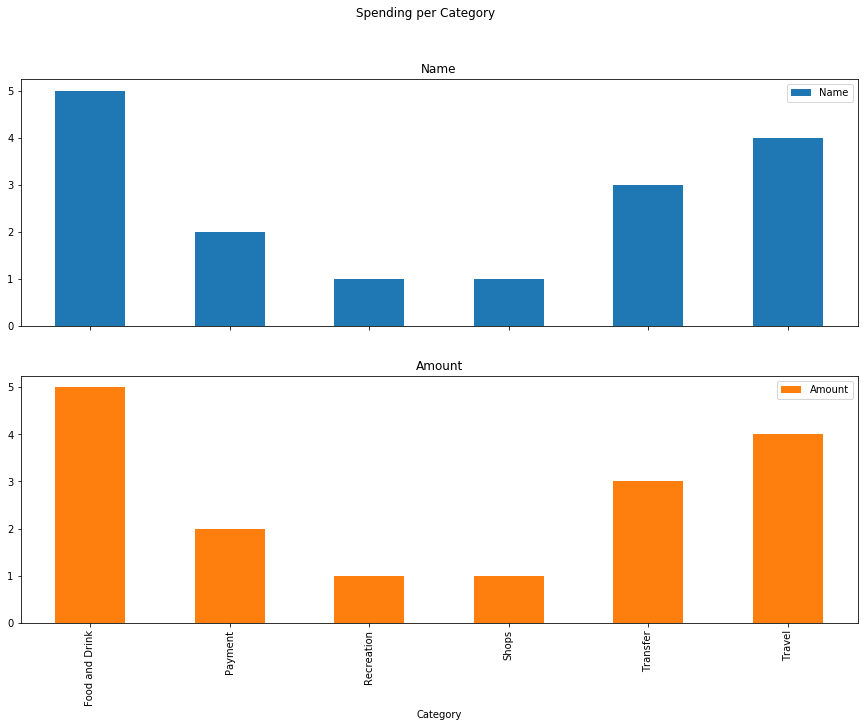

In [51]:
# Generate a bar chart with the number of transactions for each category.
grouped_count.plot.bar(subplots=True,figsize=(15,10), title="Total Transactions per Category")

### Calculate the expenses per month

In [56]:
# Calculate the expenses per month.
grouped_expenses = df.groupby(['Category']).sum()
grouped_expenses

,Amount
Category,
Food and Drink,1105.73
Payment,2103.50
Recreation,78.50
Shops,500.00
Transfer,6845.78
Travel,11.73


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000199BDC4BDC8>],
      dtype=object)

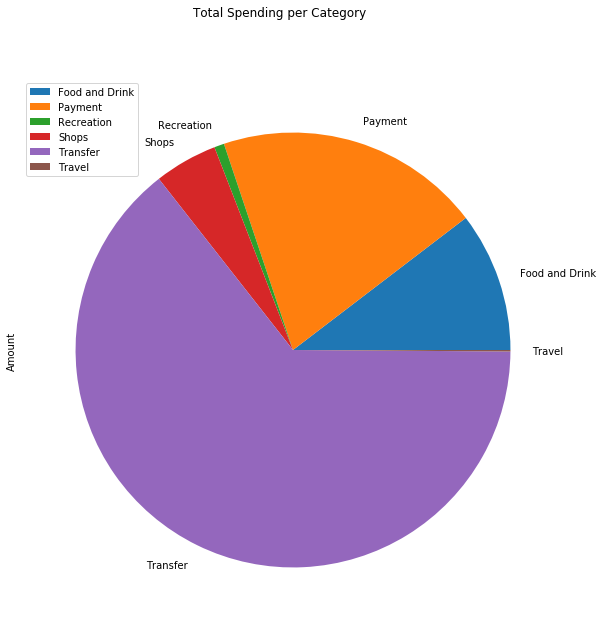

In [58]:
# Plot the total expenses per month.
grouped_expenses.plot.pie(subplots=True,figsize=(15,10), title="Total Spending per Category")